In [1]:
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"} # As everything is eager by default in tf 2.0 


import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.compat.v1.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.compat.v1.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.compat.v1.InteractiveSession(config=config)

reset_sess()

In [2]:


parameter = tfd.Exponential(rate=1., name="poisson_param").sample()
print(parameter)
rv_data_generator = tfd.Poisson(parameter, name="data_generator")
print(rv_data_generator)
data_generator = rv_data_generator.sample()
print(data_generator)
if tf.executing_eagerly():
    data_generator_ = tf.nest.pack_sequence_as(
        data_generator,
        [t.numpy() if tf.is_tensor(t) else t
         for t in tf.nest.flatten(data_generator)])
else:
    data_generator_ = sess.run(data_generator)
    
print("Value of sample from data generator random variable:", data_generator_)



tf.Tensor(0.07573364, shape=(), dtype=float32)
tfp.distributions.Poisson("data_generator/", batch_shape=[], event_shape=[], dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
Value of sample from data generator random variable: 0.0


In [3]:
def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)

In [4]:
# Defining our Assumptions
parameter = tfd.Exponential(rate=1., name="poisson_param").sample()

# Converting our TF to Numpy
[ parameter_ ] = evaluate([ parameter ])

print("Sample from exponential distribution before evaluation: ", parameter)
print("Evaluated sample from exponential distribution: ", parameter_)

Sample from exponential distribution before evaluation:  tf.Tensor(0.009993131, shape=(), dtype=float32)
Evaluated sample from exponential distribution:  0.009993131


In [5]:


[ 
    parameter_,
    data_generator_,
] = evaluate([ 
    parameter, 
    data_generator,
])

print("'parameter_' evaluated Tensor :", parameter_)
print("'data_generator_' sample evaluated Tensor :", data_generator_)



'parameter_' evaluated Tensor : 0.009993131
'data_generator_' sample evaluated Tensor : 0.0


In [6]:


lambda_1 = tfd.Exponential(rate=1., name="lambda_1") #stochastic variable
lambda_2 = tfd.Exponential(rate=1., name="lambda_2") #stochastic variable
tau = tfd.Uniform(name="tau", low=0., high=10.) #stochastic variable

# deterministic variable since we are getting results of lambda's after sampling    
new_deterministic_variable = tfd.Deterministic(name="deterministic_variable", 
                                               loc=(lambda_1.sample() + lambda_2.sample()))
print(lambda_1.sample())
print(lambda_2.sample())
print(new_deterministic_variable)

tf.Tensor(0.07651203, shape=(), dtype=float32)
tf.Tensor(2.6562717, shape=(), dtype=float32)
tfp.distributions.Deterministic("deterministic_variable/", batch_shape=[], event_shape=[], dtype=float32)


In [7]:
# Build graph
# days
n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
print(idx)
print(tau.sample())
print(lambda_1.sample())
print(lambda_2.sample())
# for n_data_points samples, select from lambda_2 if sampled tau >= day value, lambda_1 otherwise
rv_lambda_deterministic = tfd.Deterministic(tf.gather([lambda_1.sample(), lambda_2.sample()],
                    indices=tf.compat.v1.to_int32(tau.sample() >= idx)))

lambda_deterministic = rv_lambda_deterministic.sample()
# Execute graph
[lambda_deterministic_] = evaluate([lambda_deterministic])
# Show results
print("{} samples from our deterministic lambda model: \n".format(n_data_points), lambda_deterministic_ )

lambda_deterministic = rv_lambda_deterministic.sample()
[lambda_deterministic_] = evaluate([lambda_deterministic])
# Show results
print("{} samples from our deterministic lambda model: \n".format(n_data_points), lambda_deterministic_ )



W0703 16:14:56.950902 139827715921728 deprecation.py:323] From <ipython-input-7-b4a946bd1e34>:11: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


[0 1 2 3 4]
tf.Tensor(9.825687, shape=(), dtype=float32)
tf.Tensor(0.36564305, shape=(), dtype=float32)
tf.Tensor(1.2250341, shape=(), dtype=float32)
5 samples from our deterministic lambda model: 
 [2.7325678  2.7325678  2.7325678  2.7325678  0.00499385]
5 samples from our deterministic lambda model: 
 [2.7325678  2.7325678  2.7325678  2.7325678  0.00499385]


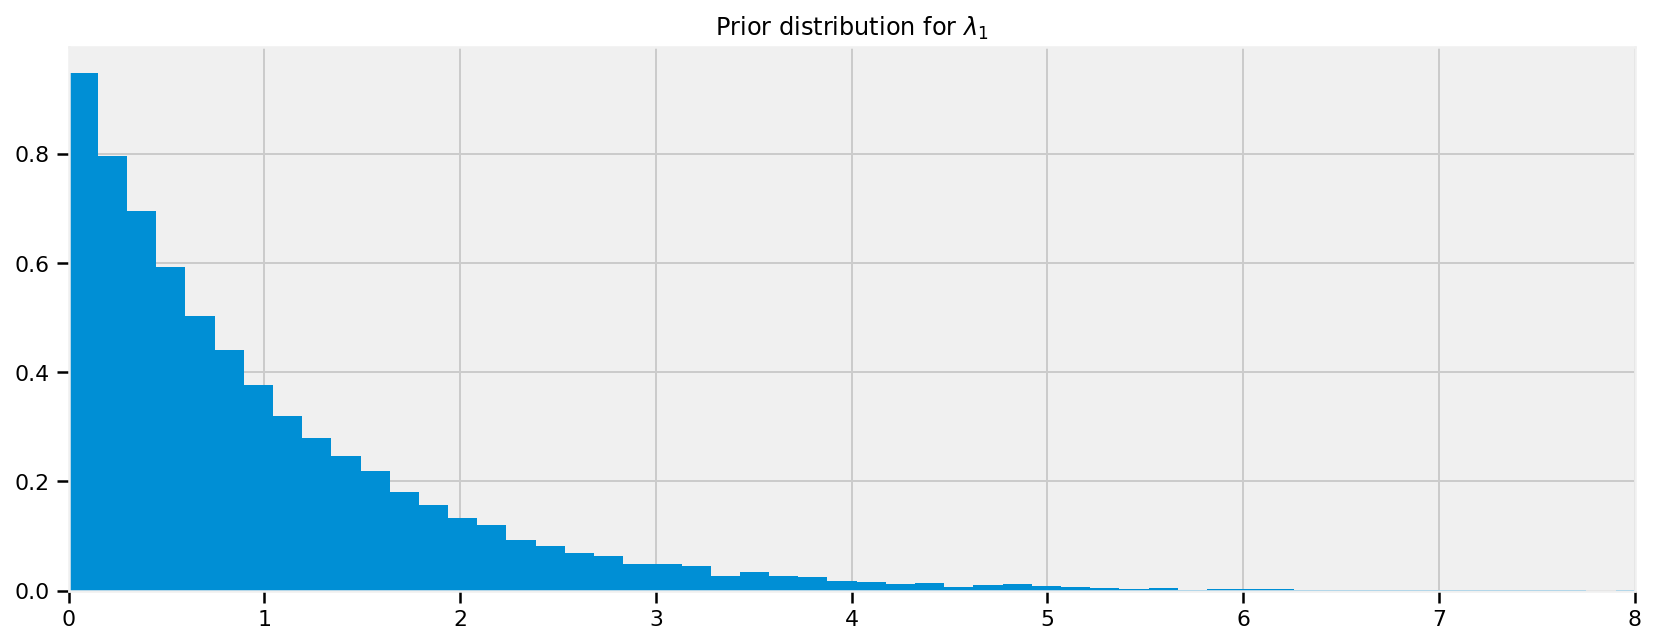

In [8]:
rv_lambda_1 = tfd.Exponential(rate=1., name="lambda_1")
lambda_1 = rv_lambda_1.sample(sample_shape=20000)
    
# Execute graph, convert TF to NumPy
[ lambda_1_ ] = evaluate([ lambda_1 ])

# Visualize our stepwise prior distribution
plt.figure(figsize(12.5, 5))
plt.hist(lambda_1_, bins=70, normed=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\lambda_1$")
plt.xlim(0, 8);



In [9]:
# Build graph
data = tf.constant([10., 5.], dtype=tf.float32)
rv_poisson = tfd.Poisson(rate=1./tf.reduce_mean(data))
poisson = rv_poisson.sample()
print(poisson)
# Execute graph
[ data_, poisson_, ] = evaluate([ data, poisson ])

# Show results
print("two predetermined data points: ", data_)
print("\n mean of our data: ", np.mean(data_))
print("\n random sample from poisson distribution \n with the mean as the poisson's rate: \n", poisson_)


tf.Tensor(0.0, shape=(), dtype=float32)
two predetermined data points:  [10.  5.]

 mean of our data:  7.5

 random sample from poisson distribution 
 with the mean as the poisson's rate: 
 0.0


In [10]:
tau = tf.compat.v1.random_uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32)

[ tau_ ] = evaluate([ tau ])

print("Value of Tau (randomly taken from DiscreteUniform(0, 80)):", tau_)

Value of Tau (randomly taken from DiscreteUniform(0, 80)): [17]


In [11]:
alpha = 1./8.

lambdas  = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2])  
[ lambda_1_, lambda_2_ ] = evaluate( lambdas )
print("Lambda 1 (randomly taken from Gamma(α) distribution): ", lambda_1_)
print("Lambda 2 (randomly taken from Gamma(α) distribution): ", lambda_2_)

Lambda 1 (randomly taken from Gamma(α) distribution):  54.328
Lambda 2 (randomly taken from Gamma(α) distribution):  29.484703


In [12]:
data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau_),
                      tfd.Poisson(rate=lambda_2_).sample(sample_shape= (80 - tau_))], axis=0)
days_range = tf.range(80)
[ data_, days_range_ ] = evaluate([ data, days_range ])
print("Artificial day-by-day user SMS count created by sampling: \n", data_)

Artificial day-by-day user SMS count created by sampling: 
 [44. 64. 50. 56. 56. 50. 43. 50. 46. 46. 58. 59. 44. 56. 63. 38. 59. 32.
 30. 25. 30. 29. 28. 34. 24. 22. 41. 31. 38. 36. 24. 31. 26. 23. 31. 35.
 25. 34. 30. 29. 32. 25. 27. 37. 28. 21. 29. 36. 28. 31. 19. 37. 31. 24.
 26. 36. 24. 26. 24. 32. 28. 28. 30. 33. 23. 28. 33. 28. 21. 28. 36. 32.
 22. 23. 29. 28. 30. 38. 32. 40.]


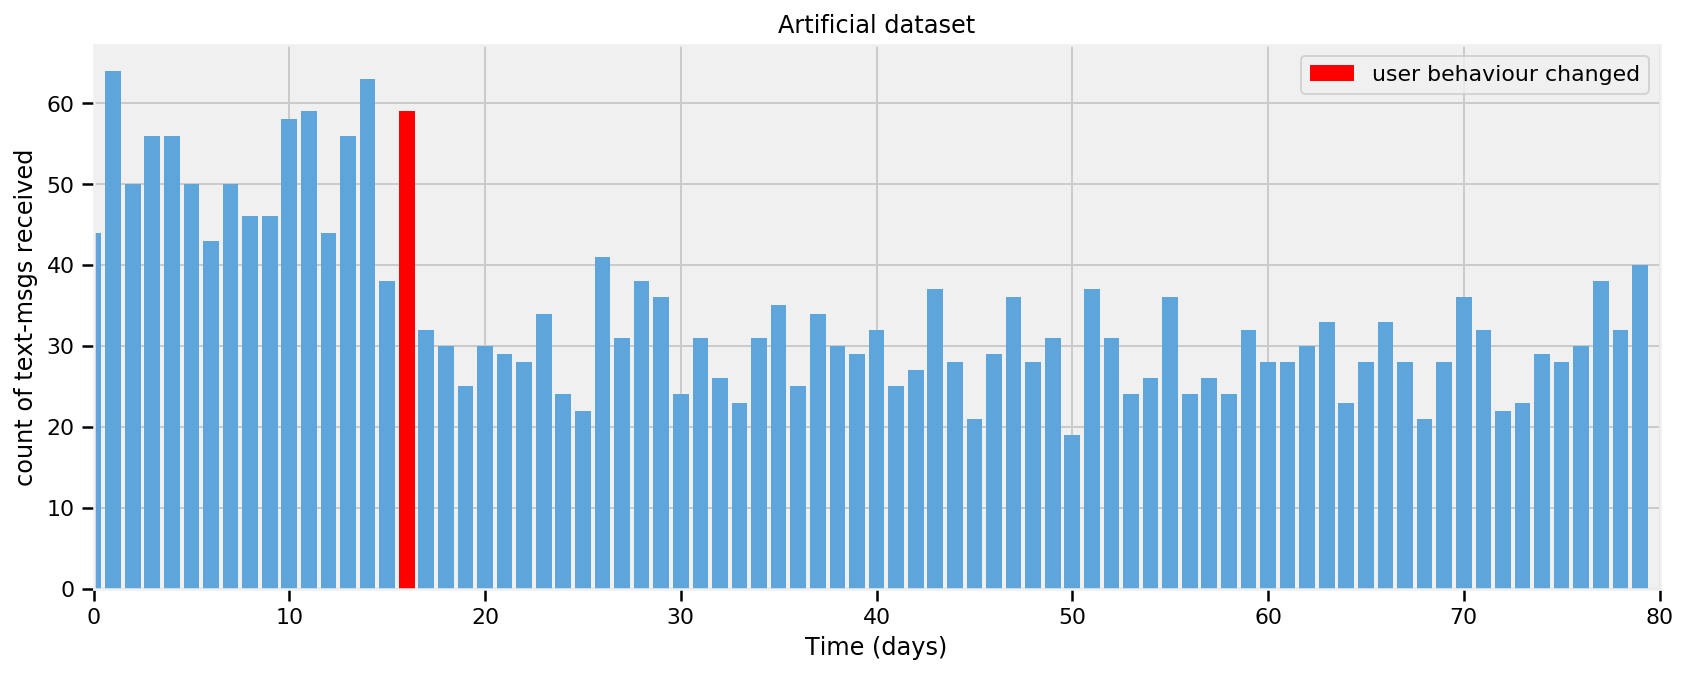

In [13]:


plt.bar(days_range_, data_, color=TFColor[3])
plt.bar(tau_ - 1, data_[tau_ - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();



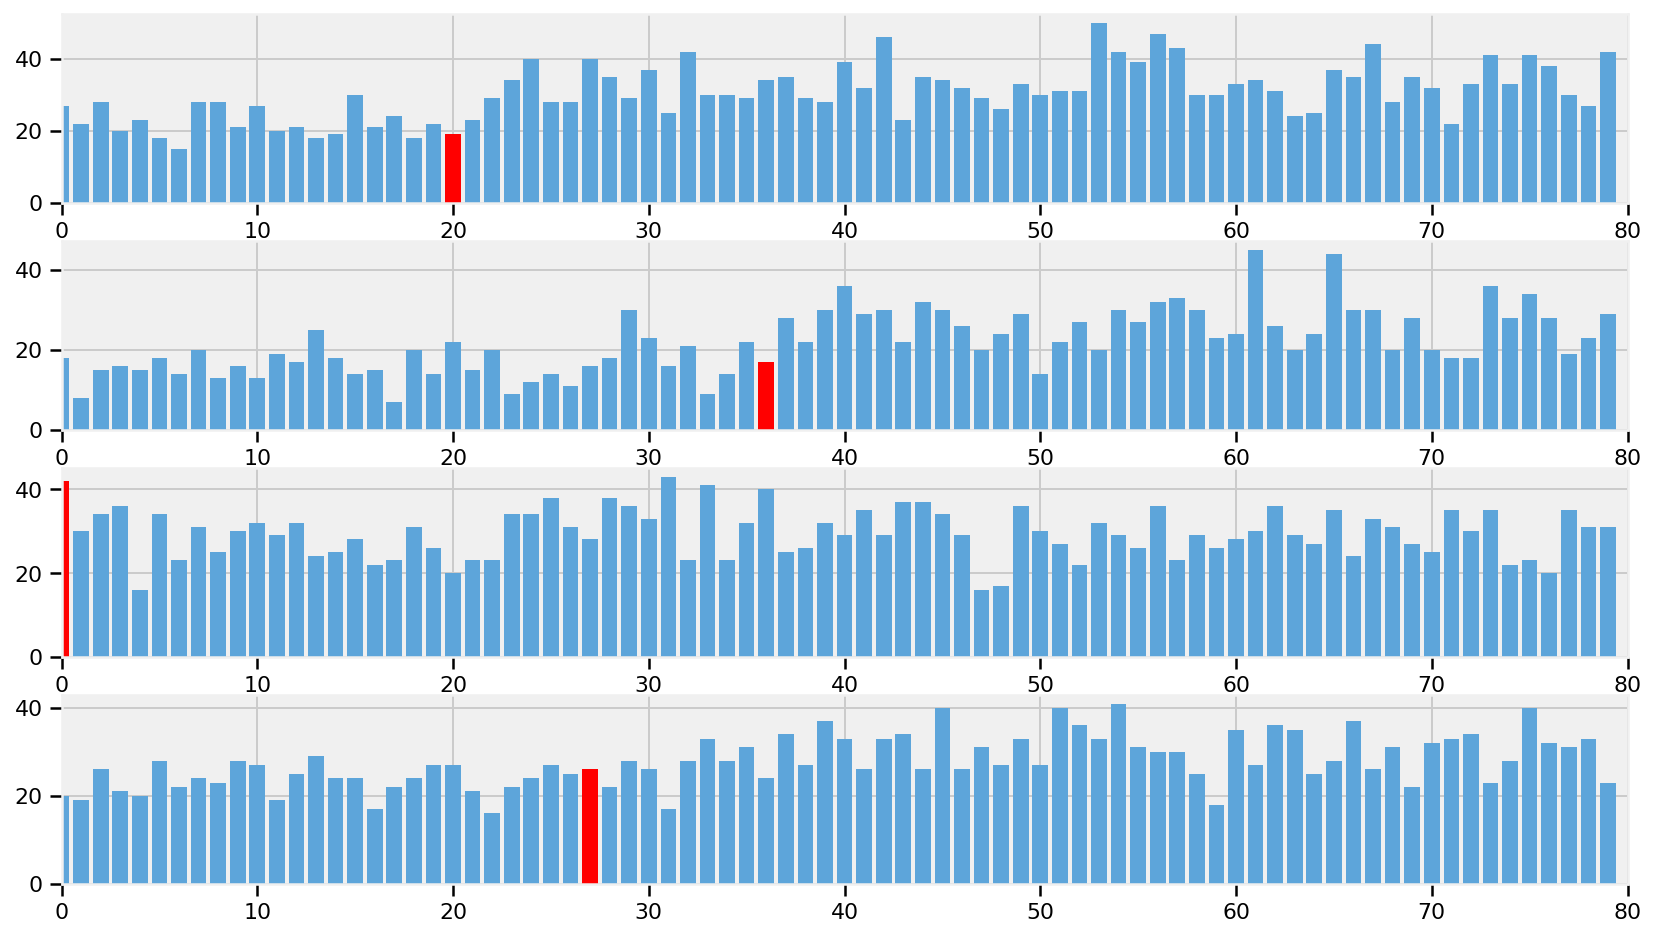

In [14]:
def plot_artificial_sms_dataset():   
    tau = tf.compat.v1.random_uniform(shape=[1], 
                            minval=0, 
                            maxval=80,
                            dtype=tf.int32)
    alpha = 1./8.
    lambdas  = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2]) 
    [ lambda_1_, lambda_2_ ] = evaluate( lambdas )
    data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau),
                      tfd.Poisson(rate=lambda_2_).sample(sample_shape= (80 - tau))], axis=0)
    days_range = tf.range(80)
    
    [ 
        tau_,
        data_,
        days_range_,
    ] = evaluate([ 
        tau,
        data,
        days_range,
    ])
    
    plt.bar(days_range_, data_, color=TFColor[3])
    plt.bar(tau_ - 1, data_[tau_ - 1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

plt.figure(figsize(12.5, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()



In [15]:


reset_sess()

# The parameters are the bounds of the Uniform.
rv_p = tfd.Uniform(low=0., high=1., name='p')



In [16]:
reset_sess()

#set constants
prob_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step

occurrences = tfd.Bernoulli(probs=prob_true).sample(sample_shape=N, seed=10)
occurrences_sum = tf.reduce_sum(occurrences)
occurrences_mean = tf.reduce_mean(tf.cast(occurrences,tf.float32))

[ 
    occurrences_,
    occurrences_sum_,
    occurrences_mean_,
] = evaluate([ 
    occurrences, 
    occurrences_sum,
    occurrences_mean,
])

print("Array of {} Occurences:".format(N), occurrences_) 
print("(Remember: Python treats True == 1, and False == 0)")
print("Sum of (True == 1) Occurences:", occurrences_sum_)

Array of 1500 Occurences: [0 0 0 ... 0 1 0]
(Remember: Python treats True == 1, and False == 0)
Sum of (True == 1) Occurences: 76


In [17]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % occurrences_mean_)
print("Does this equal the true frequency? %s" % (occurrences_mean_ == prob_true))

What is the observed frequency in Group A? 0.0507
Does this equal the true frequency? False


In [18]:


def joint_log_prob(occurrences, prob_A):
    """
    Joint log probability optimization function.
        
    Args:
      occurrences: An array of binary values (0 & 1), representing 
                   the observed frequency
      prob_A: scalar estimate of the probability of a 1 appearing 
    Returns: 
      sum of the joint log probabilities from all of the prior and conditional distributions
    """  
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_occurrences = tfd.Bernoulli(probs=prob_A)
    return (
        rv_prob_A.log_prob(prob_A)
        + tf.reduce_sum(rv_occurrences.log_prob(occurrences))
    )



In [21]:
number_of_steps = 48000 #@param {type:"slider", min:2000, max:50000, step:100}
#@markdown (Default is 18000).
burnin = 25000 #@param {type:"slider", min:0, max:30000, step:100}
#@markdown (Default is 1000).
leapfrog_steps=2 #@param {type:"slider", min:1, max:9, step:1}
#@markdown (Default is 6).

# Set the chain's start state.
initial_chain_state = [
    tf.reduce_mean(tf.compat.v1.to_float(occurrences)) 
    * tf.ones([], dtype=tf.float32, name="init_prob_A")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity()   # Maps R to R.  
]

# Define a closure over our joint_log_prob.
# The closure makes it so the HMC doesn't try to change the `occurrences` but
# instead determines the distributions of other parameters that might generate
# the `occurrences` we observed.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(occurrences, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_prob_A
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)



In [22]:
print(initial_chain_state)
print(unconstraining_bijectors)
print(unnormalized_posterior_log_prob)
print(kernel_results)
print(posterior_prob_A)

[<tf.Tensor: id=50964079, shape=(), dtype=float32, numpy=0.050666668>]
<function <lambda> at 0x7f2a99d1c2f0>
TransformedTransitionKernelResults(transformed_state=[<tf.Tensor: id=101927339, shape=(48000,), dtype=float32, numpy=
array([0.04842423, 0.04996372, 0.04927967, ..., 0.05570399, 0.04278427,
       0.05831826], dtype=float32)>], inner_results=MetropolisHastingsKernelResults(accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(log_acceptance_correction=<tf.Tensor: id=101927340, shape=(48000,), dtype=float32, numpy=
array([-0.15322846, -0.05558437,  0.04661655, ...,  0.05573367,
        0.65205395,  0.09182674], dtype=float32)>, target_log_prob=<tf.Tensor: id=101927341, shape=(48000,), dtype=float32, numpy=
array([-300.79166, -300.7175 , -300.7411 , ..., -301.08316, -301.78708,
       -301.5449 ], dtype=float32)>, grads_target_log_prob=[<tf.Tensor: id=101927342, shape=(48000,), dtype=float32, numpy=
array([  72.99682 ,   22.213314,   44.405926, ..., -143.6466  ,
        

In [23]:
# Initialize any created variables.
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()

In [24]:


evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_A_,
    kernel_results_,
] = evaluate([
    posterior_prob_A,
    kernel_results,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))

burned_prob_A_trace_ = posterior_prob_A_[burnin:]



acceptance rate: 0.7238958333333333


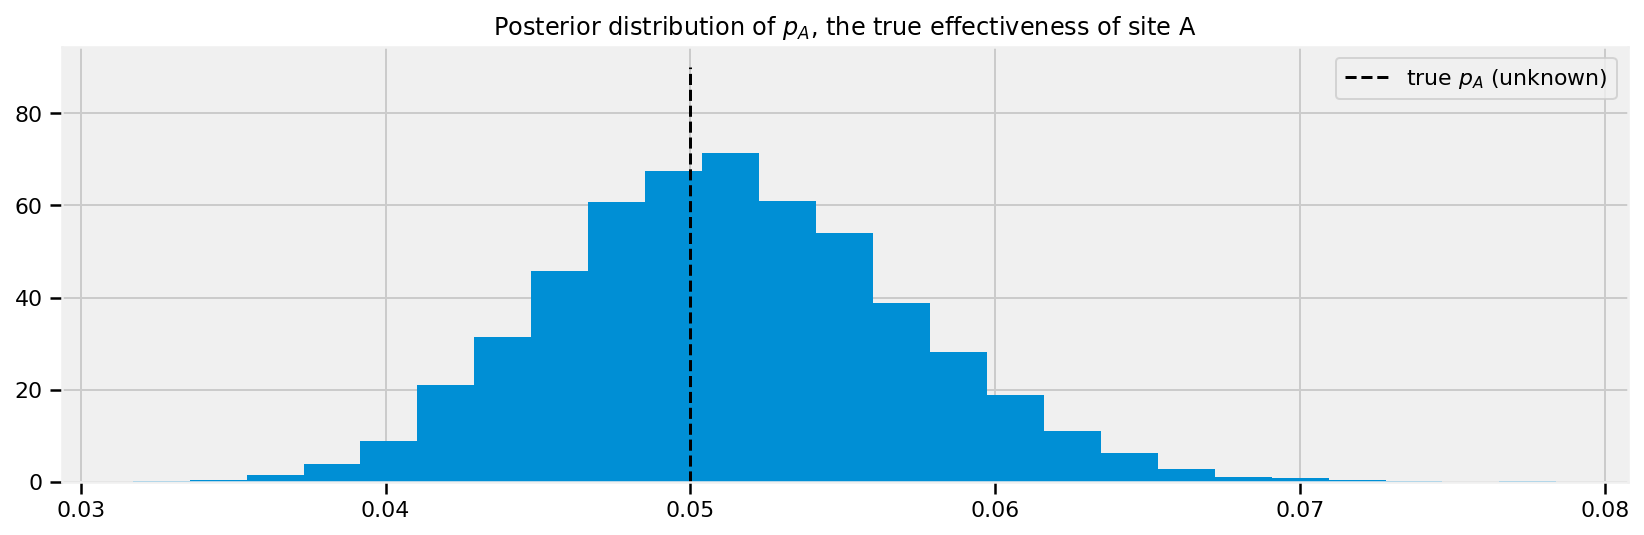

In [28]:
plt.figure(figsize(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(prob_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_prob_A_trace_, bins=25, histtype="stepfilled", normed=True)
plt.legend();

In [29]:


reset_sess()

#these two quantities are unknown to us.
true_prob_A_ = 0.05
true_prob_B_ = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A_ = 1500
N_B_ = 750

#generate some observations
observations_A = tfd.Bernoulli(name="obs_A", 
                          probs=true_prob_A_).sample(sample_shape=N_A_, seed=6.45)
observations_B = tfd.Bernoulli(name="obs_B", 
                          probs=true_prob_B_).sample(sample_shape=N_B_, seed=6.45)
[ 
    observations_A_,
    observations_B_,
] = evaluate([ 
    observations_A, 
    observations_B, 
])

print("Obs from Site A: ", observations_A_[:30], "...")
print("Observed Prob_A: ", np.mean(observations_A_), "...")
print("Obs from Site B: ", observations_B_[:30], "...")
print("Observed Prob_B: ", np.mean(observations_B_))



Obs from Site A:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_A:  0.05466666666666667 ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_B:  0.058666666666666666


In [30]:


def delta(prob_A, prob_B):
    """
    Defining the deterministic delta function. This is our unknown of interest.
        
    Args:
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B
    Returns: 
      Difference between prob_A and prob_B
    """
    return prob_A - prob_B

  
def double_joint_log_prob(observations_A, observations_B, 
                   prob_A, prob_B):
    """
    Joint log probability optimization function.
        
    Args:
      observations_A: An array of binary values representing the set of 
                      observations for site A
      observations_B: An array of binary values representing the set of 
                      observations for site B 
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B 
    Returns: 
      Joint log probability optimization function.
    """
    tfd = tfp.distributions
  
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)
  
    rv_obs_A = tfd.Bernoulli(probs=prob_A)
    rv_obs_B = tfd.Bernoulli(probs=prob_B)
  
    return (
        rv_prob_A.log_prob(prob_A)
        + rv_prob_B.log_prob(prob_B)
        + tf.reduce_sum(rv_obs_A.log_prob(observations_A))
        + tf.reduce_sum(rv_obs_B.log_prob(observations_B))
    )



In [31]:
number_of_steps = 37200 #@param {type:"slider", min:2000, max:50000, step:100}
#@markdown (Default is 18000).
burnin = 1000 #@param {type:"slider", min:0, max:30000, step:100}
#@markdown (Default is 1000).
leapfrog_steps=3 #@param {type:"slider", min:1, max:9, step:1}
#@markdown (Default is 6).


# Set the chain's start state.
initial_chain_state = [    
    tf.reduce_mean(tf.compat.v1.to_float(observations_A)) * tf.ones([], dtype=tf.float32, name="init_prob_A"),
    tf.reduce_mean(tf.compat.v1.to_float(observations_B)) * tf.ones([], dtype=tf.float32, name="init_prob_B")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),   # Maps R to R.
    tfp.bijectors.Identity()    # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: double_joint_log_prob(observations_A, observations_B, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob_A,
    posterior_prob_B
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()

In [37]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_A_,
    posterior_prob_B_,
    kernel_results_
] = evaluate([
    posterior_prob_A,
    posterior_prob_B,
    kernel_results
])
    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print(burnin)
burned_prob_A_trace_ = posterior_prob_A_[burnin:]
burned_prob_B_trace_ = posterior_prob_B_[burnin:]
burned_delta_trace_ = (posterior_prob_A_ - posterior_prob_B_)[burnin:]

acceptance rate: 0.5503225806451613
1000


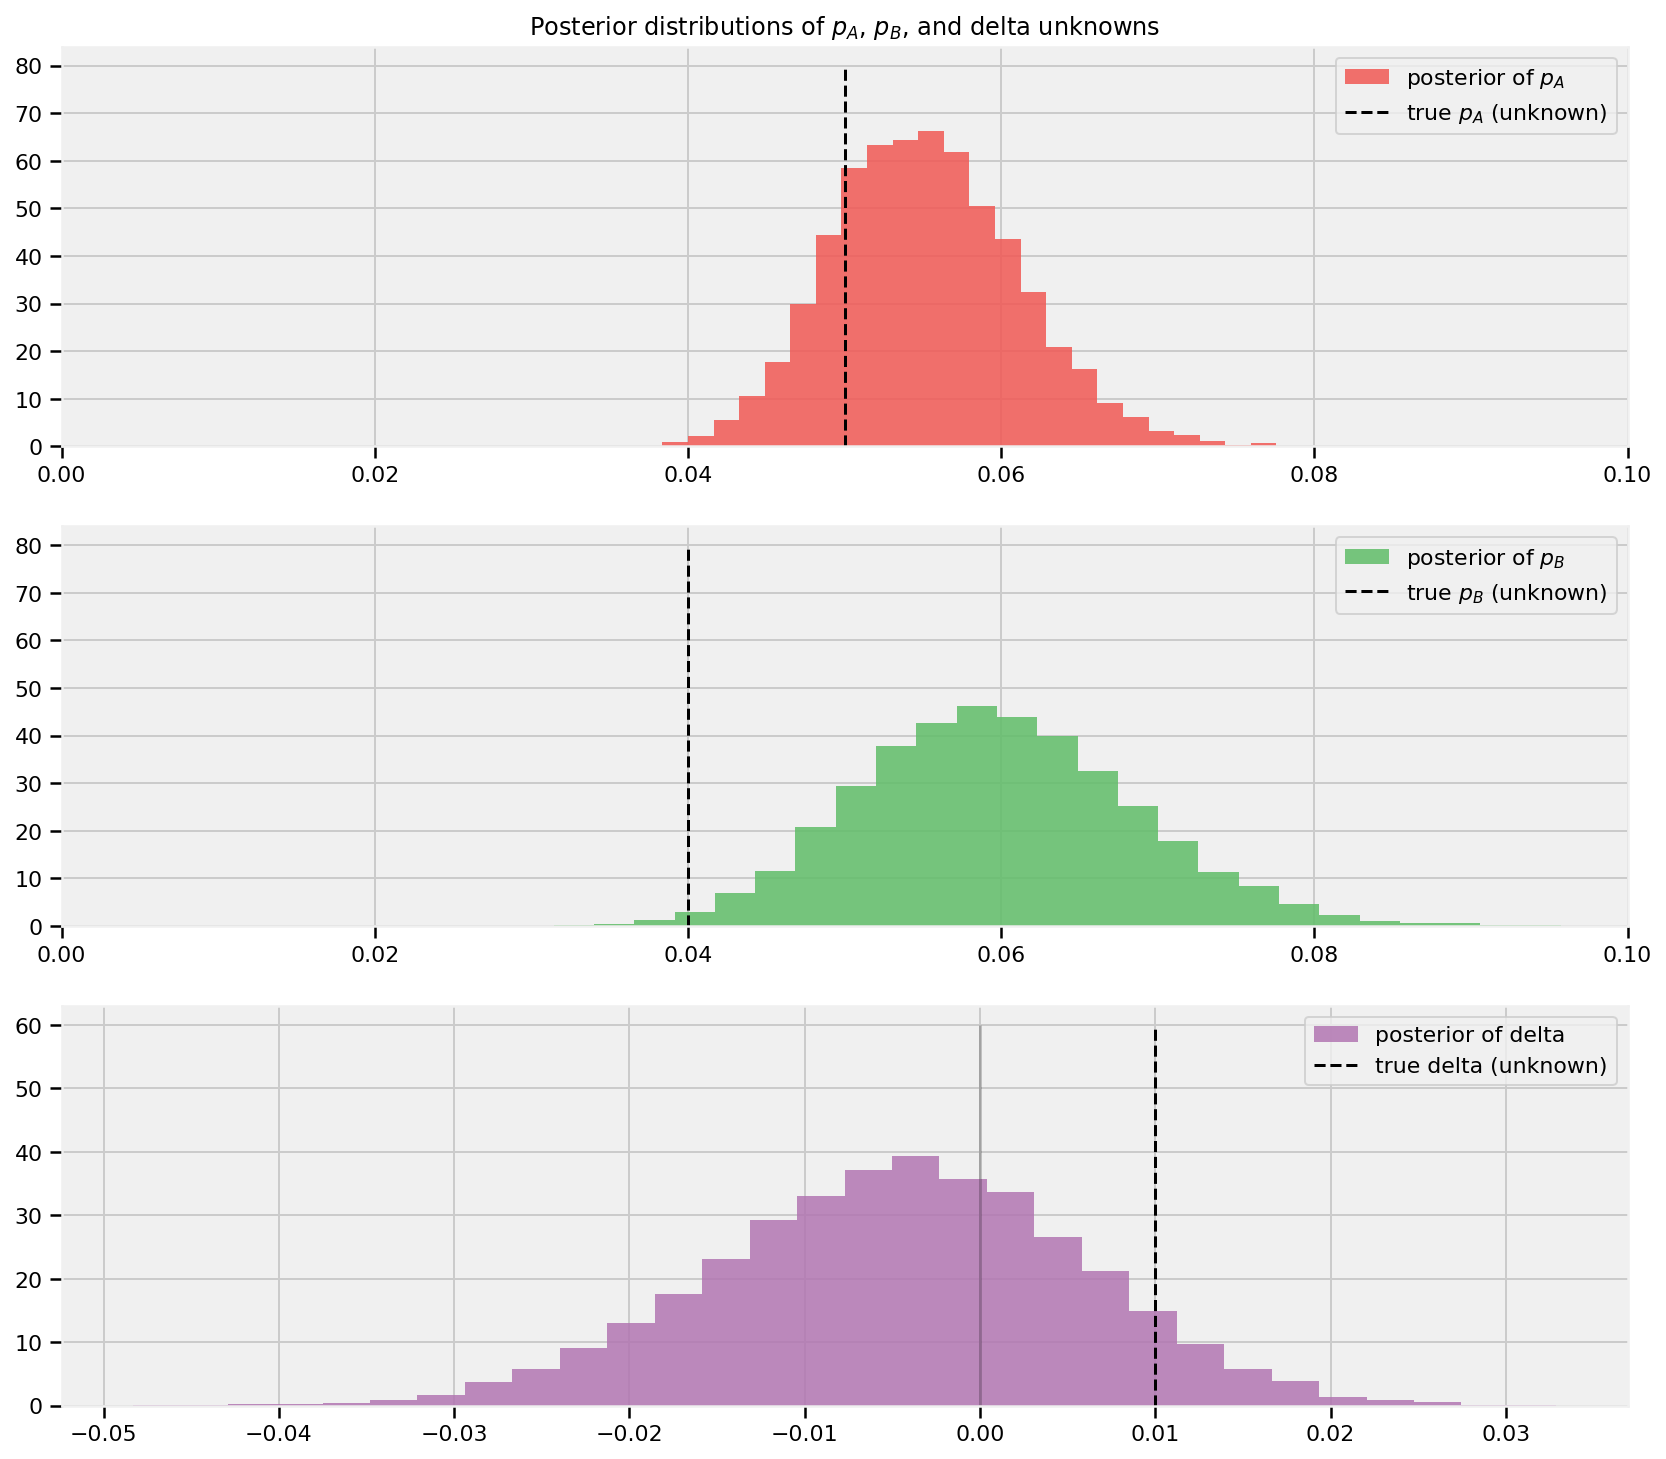

In [35]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(burned_prob_A_trace_, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color=TFColor[0], normed=True)
plt.vlines(true_prob_A_, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(burned_prob_B_trace_, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color=TFColor[2], normed=True)
plt.vlines(true_prob_B_, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(burned_delta_trace_, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color=TFColor[6], normed=True)
plt.vlines(true_prob_A_ - true_prob_B_, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");


In [36]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(burned_delta_trace_ < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(burned_delta_trace_ > 0))

Probability site A is WORSE than site B: 0.665
Probability site A is BETTER than site B: 0.335


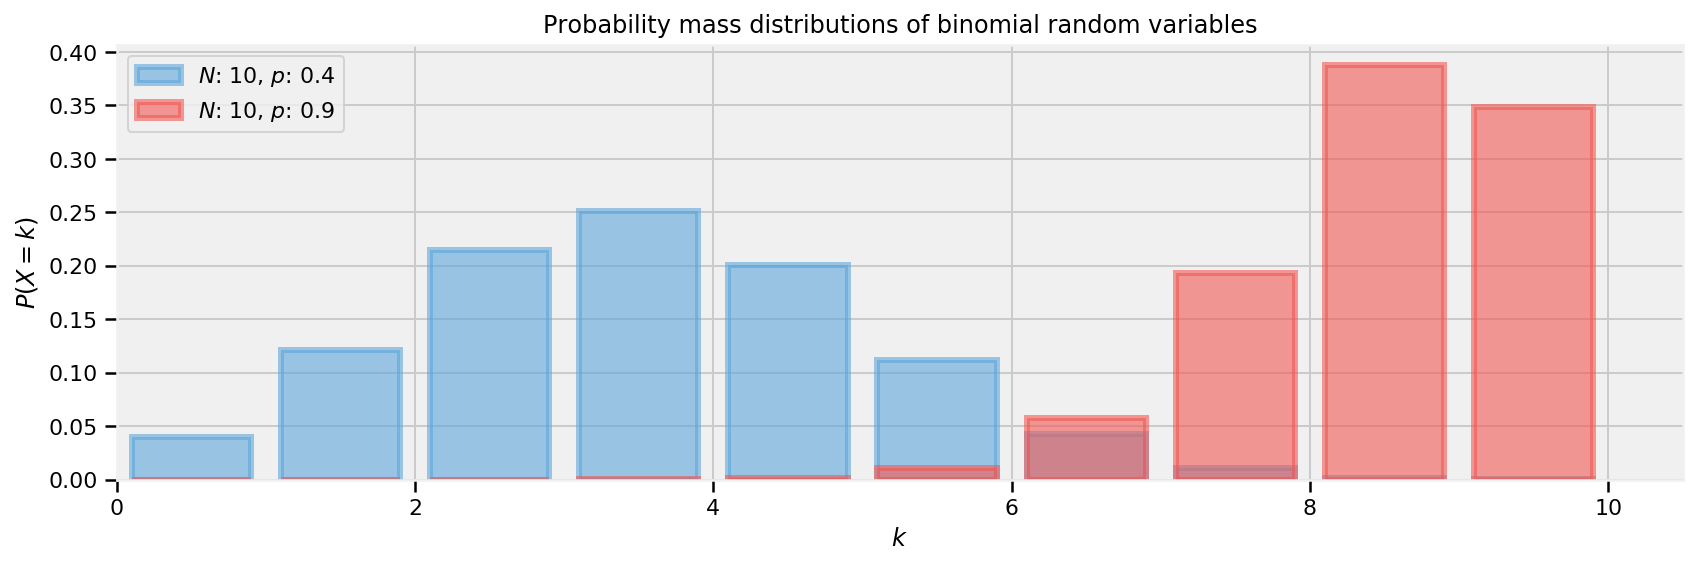

In [38]:


N = 10.
k_values = tf.range(start=0, limit=(N + 1), dtype=tf.float32)
rv_probs_1 = tfd.Binomial(total_count=N, probs=.4).prob(k_values)
rv_probs_2 = tfd.Binomial(total_count=N, probs=.9).prob(k_values)

# Execute graph
[
    k_values_,
    rv_probs_1_,
    rv_probs_2_,
] = evaluate([
    k_values,
    rv_probs_1,
    rv_probs_2,
])

# Display results
plt.figure(figsize=(12.5, 4))
colors = [TFColor[3], TFColor[0]] 

plt.bar(k_values_ - 0.5, rv_probs_1_, color=colors[0],
        edgecolor=colors[0],
        alpha=0.6,
        label="$N$: %d, $p$: %.1f" % (10., .4),
        linewidth=3)
plt.bar(k_values_ - 0.5, rv_probs_2_, color=colors[1],
        edgecolor=colors[1],
        alpha=0.6,
        label="$N$: %d, $p$: %.1f" % (10., .9),
        linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");



In [39]:
reset_sess()

N = 100
rv_p = tfd.Uniform(name="freq_cheating", low=0., high=1.)

In [40]:
N = 100
reset_sess()
rv_p = tfd.Uniform(name="freq_cheating", low=0., high=1.)
true_answers = tfd.Bernoulli(name="truths", 
                             probs=rv_p.sample()).sample(sample_shape=N, 
                                                      seed=5)
# Execute graph
[
    true_answers_,
] = evaluate([
    true_answers,
])

print(true_answers_)
print(true_answers_.sum())

[1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1
 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0]
39


In [41]:


N = 100
first_coin_flips = tfd.Bernoulli(name="first_flips", 
                                 probs=0.5).sample(sample_shape=N, 
                                                   seed=5)
# Execute graph
[
    first_coin_flips_,
] = evaluate([
    first_coin_flips,
])

print(first_coin_flips_)



[1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1]


In [42]:


N = 100
second_coin_flips = tfd.Bernoulli(name="second_flips", 
                                  probs=0.5).sample(sample_shape=N, 
                                                    seed=5)
# Execute graph
[
    second_coin_flips_,
] = evaluate([
    second_coin_flips,
])

print(second_coin_flips_)



[0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1
 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1]


In [48]:


def observed_proportion_calc(t_a = true_answers, 
                             fc = first_coin_flips,
                             sc = second_coin_flips):
    """
    Unnormalized log posterior distribution function
        
    Args:
      t_a: array of binary variables representing the true answers
      fc: array of binary variables representing the simulated first flips 
      sc: array of binary variables representing the simulated second flips
    Returns: 
      Observed proportion of coin flips
    Closure over: N
    """
    observed = fc * t_a + (1 - fc) * sc
    observed_proportion = tf.compat.v1.to_float(tf.reduce_sum(observed)) / tf.compat.v1.to_float(N)
    
    return tf.compat.v1.to_float(observed_proportion)



In [49]:


observed_proportion_val = observed_proportion_calc(t_a=true_answers_,
                                                   fc=first_coin_flips_,
                                                   sc=second_coin_flips_)
# Execute graph
[
    observed_proportion_val_,
] = evaluate([
    observed_proportion_val,
])

print(observed_proportion_val_)



0.45


In [51]:


total_count = 100
total_yes = 45



In [56]:


def coin_joint_log_prob(total_yes, total_count, lies_prob):
    """
    Joint log probability optimization function.
      
    Args:
      headsflips: Integer for total number of observed heads flips
      N: Integer for number of total observation
      lies_prob: Test probability of a heads flip (1) for a Binomial distribution
    Returns: 
      Joint log probability optimization function.
    """
  
    rv_lies_prob = tfd.Uniform(name="rv_lies_prob",low=0., high=1.)

    cheated = tfd.Bernoulli(probs=tf.compat.v1.to_float(lies_prob)).sample(total_count)
    first_flips = tfd.Bernoulli(probs=0.5).sample(total_count)
    second_flips = tfd.Bernoulli(probs=0.5).sample(total_count)
    observed_probability = tf.reduce_sum(tf.compat.v1.to_float(
        cheated * first_flips + (1 - first_flips) * second_flips)) / total_count

    rv_yeses = tfd.Binomial(name="rv_yeses",
                total_count=float(total_count),
                probs=observed_probability)
    
    return (
        rv_lies_prob.log_prob(lies_prob)
        + tf.reduce_sum(rv_yeses.log_prob(tf.compat.v1.to_float(total_yes)))
        )



In [57]:


burnin = 15000
num_of_steps = 40000
total_count=100

# Set the chain's start state.
initial_chain_state = [
    0.4 * tf.ones([], dtype=tf.float32, name="init_prob")
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: coin_joint_log_prob(total_yes, total_count,  *args)

# Defining the Metropolis-Hastings
# We use a Metropolis-Hastings method here instead of Hamiltonian method
# because the coin flips in the above example are non-differentiable and cannot
# be used with HMC.
metropolis=tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    seed=54)

# Sample from the chain.
[
    posterior_p
], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=metropolis,
    parallel_iterations=1,
    name='Metropolis-Hastings_coin-flips')



In [58]:


# Content Warning: This cell can take up to 5 minutes in Graph Mode
[
    posterior_p_,
    kernel_results_
] = evaluate([
    posterior_p,
    kernel_results,
])
 
print("acceptance rate: {}".format(
    kernel_results_.is_accepted.mean()))
# print("prob_p trace: ", posterior_p_)
# print("prob_p burned trace: ", posterior_p_[burnin:])
burned_cheating_freq_samples_ = posterior_p_[burnin:]



acceptance rate: 0.121925


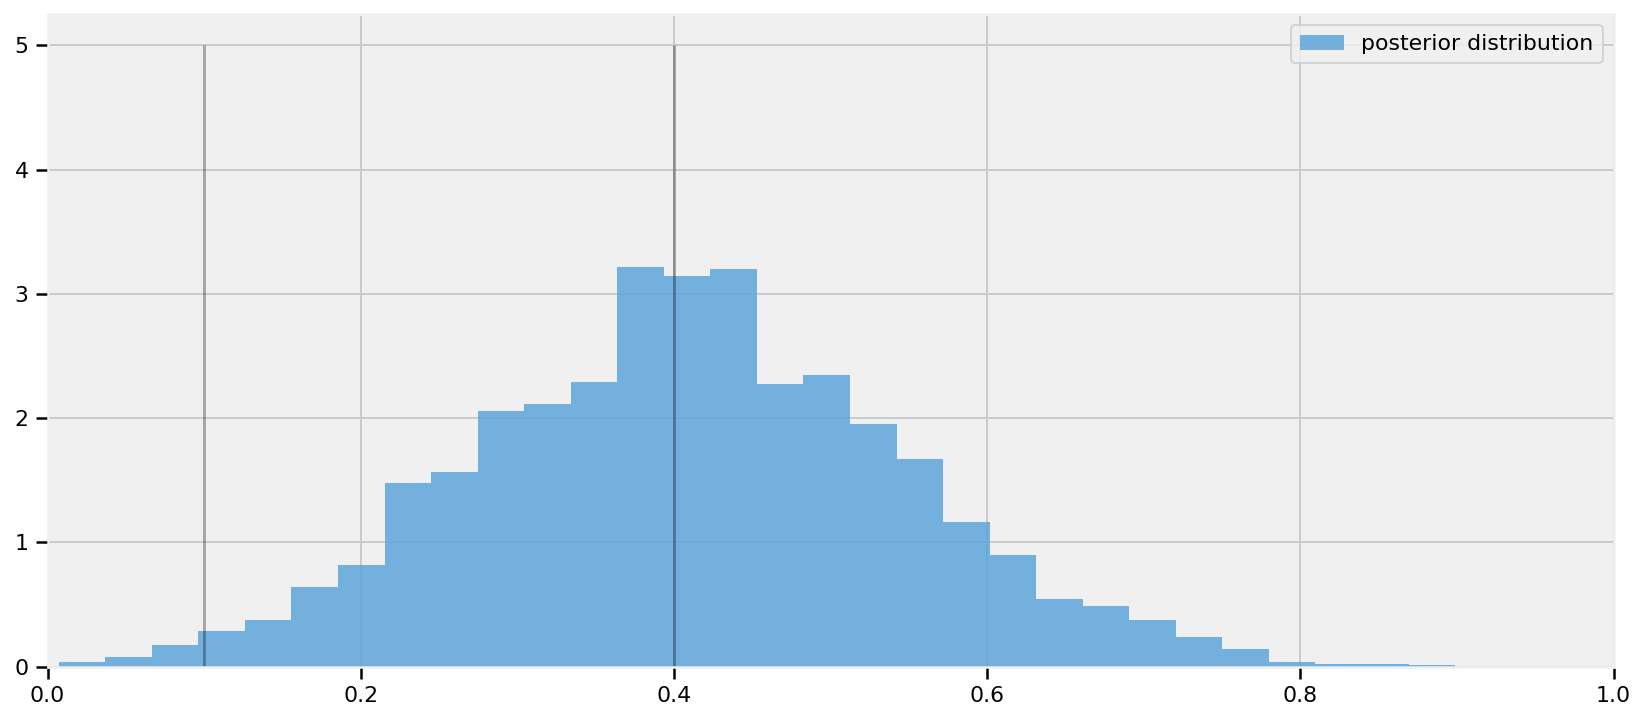

In [59]:


plt.figure(figsize(12.5, 6))
p_trace_ = burned_cheating_freq_samples_
plt.hist(p_trace_, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color=TFColor[3])
plt.vlines([.1, .40], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();



In [66]:


N = 100.
total_yes = 35.

def alt_joint_log_prob(yes_responses, N, prob_cheating):
    """
    Alternative joint log probability optimization function.
        
    Args:
      yes_responses: Integer for total number of affirmative responses
      N: Integer for number of total observation
      prob_cheating: Test probability of a student actually cheating
    Returns: 
      Joint log probability optimization function.
    """
    tfd = tfp.distributions
  
    rv_prob = tfd.Uniform(name="rv_prob", low=0., high=1.)
    p_skewed = 0.5 * prob_cheating + 0.25
    rv_yes_responses = tfd.Binomial(name="rv_yes_responses",
                                     total_count=tf.compat.v1.to_float(N), 
                                     probs=p_skewed)

    return (
        rv_prob.log_prob(prob_cheating)
        + tf.reduce_sum(rv_yes_responses.log_prob(tf.compat.v1.to_float(yes_responses)))
    )



In [68]:
number_of_steps = 25000
burnin = 2500

# Set the chain's start state.
initial_chain_state = [
    0.2 * tf.ones([], dtype=tf.float32, name="init_skewed_p")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.
]

# Define a closure over our joint_log_prob.
# unnormalized_posterior_log_prob = lambda *args: alt_joint_log_prob(headsflips, total_yes, N, *args)
unnormalized_posterior_log_prob = lambda *args: alt_joint_log_prob(total_yes, N, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='skewed_step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    ) 

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=2,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_skewed_p
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
# This prevents a FailedPreconditionError


In [69]:
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()

In [70]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_skewed_p_,
    kernel_results_
] = evaluate([
    posterior_skewed_p,
    kernel_results
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
# print("final step size: {}".format(
#     kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

# print("p_skewed trace: ", posterior_skewed_p_)
# print("p_skewed burned trace: ", posterior_skewed_p_[burnin:])
freq_cheating_samples_ = posterior_skewed_p_[burnin:]

acceptance rate: 0.54248


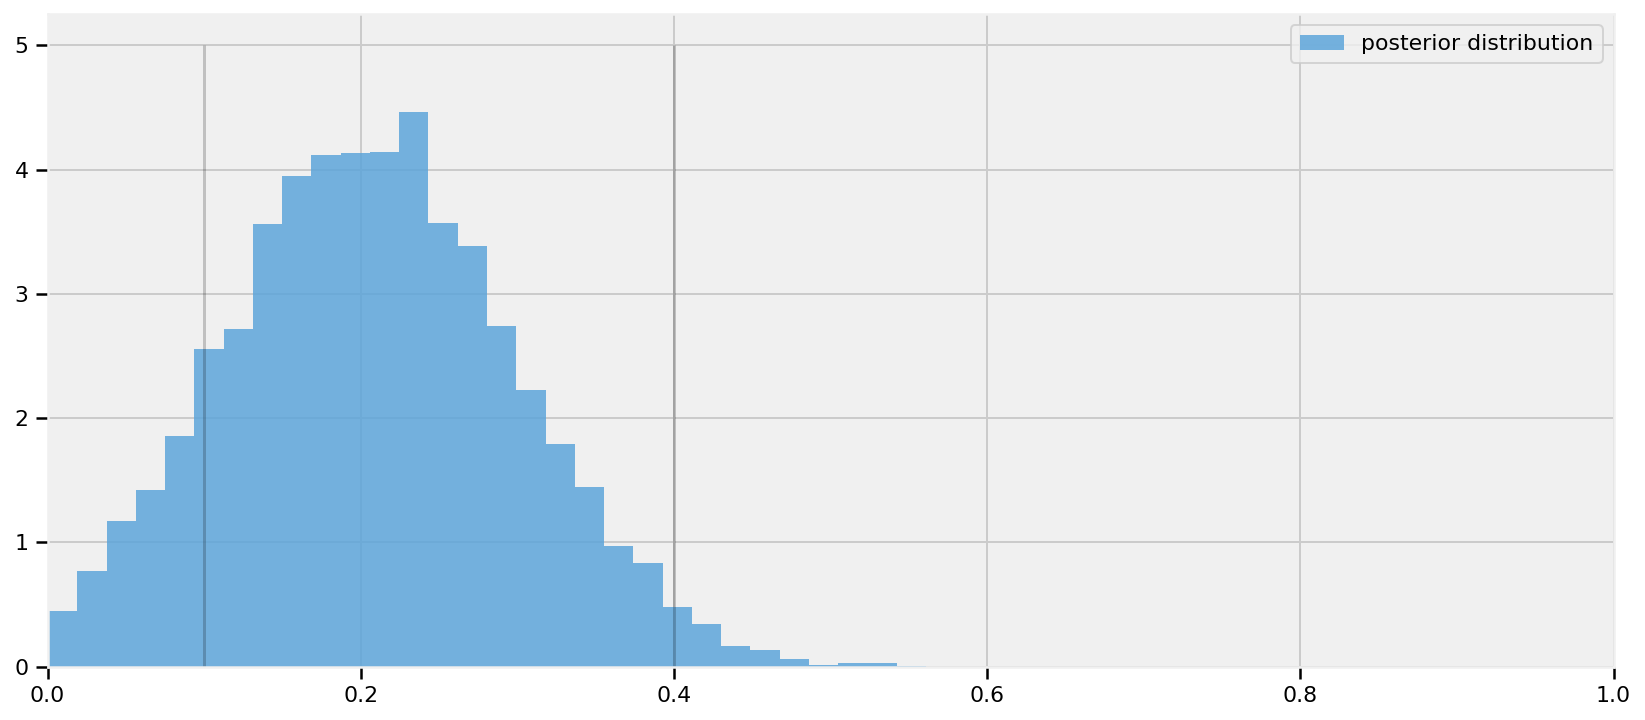

In [71]:


plt.figure(figsize(12.5, 6))
p_trace_ = freq_cheating_samples_
plt.hist(p_trace_, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color=TFColor[3])
plt.vlines([.1, .40], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

